# Simaese Model Architecture Implementation Proof of Concept

This notebook (and the accompanying files: train_mnist.py, model_2_mnist.py) are a responce to my initial attempts of training model 1. The model was severely underfitting the data with no convergence at all during training. I had many initial speculations as to why this was. I have just attempted to implement some of those, but quickly realized that there were too many considerations to test all at once. Feeling somewhat aimless as to how to proceed, I decided to implement the model architecure and data wrangling process on MNIST to gain insight into possible errors in my signature data implemplmentaion. 


I am also going to document changes I am making to the model architecture here.

- One possible source of errors is that the data wrangling process I went through to get the signature data in the correct format for model 1's architecture was fairly complicated and opened up many possible error sources I was blind to. The reason for this is because I wanted the input for the model to be a single tensors, But I realize now that I can simplify the model, reduce the amount of human manipulatation and potential errors I introduce to the data, and simplify the training loop if I have the model take in the two image tensor batches seperately. 

- Additionally, I have modified the Train class to reflect the above modifcication to the model. For each epoch of the training loop, there are now two for loops that will pull out a batch from the dataloader. From the target vectors from the two batches pulled from the dataloader, a new target vector is created on the spot that stores binary classes of whether the two images along the same index belong to the same class as each other. 

- Another change I have made to the model architecture is that I have removed the greater than equal to function that was called on the cosine similarity tensor before model output. This is because I realized that using the threshold function torch.ge() makes backpropagation impossible because threshold functions are not differentiable. Instead I have switch this out for sigmoid. Predicitons can then be derived with torch.ge() outside of the model.

- I've also added error handling to check if the embeddings interal to the model are not of the same shape due to the specific length of the dataset. 


I experimented with 3 versions of the training script in this notebook as well. Aside from the major changes listed above, which all of them share, the differences between the three stategies are found in the technique used to load in the training data. These differences are discussed within each of the idividual training scripts.

#### Also, as a point of clarification. I realized that my plots of the learning curves for the first two training sessions say train loss/acc in their labels. This is incorrect, they should say validation loss/acc.

### Here I am going to load in the dataset 

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)


### Load in Model

This is the adjusted model for the mnist

In [2]:
from model_2_mnist import SiameseNet 

model = SiameseNet()

Below I am running a forward pass on a single example

In [3]:
# get image from trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)


# get two images from the batch
image1 = images[0].unsqueeze(0) # unsqueeze to add a batch dimension
image2 = images[1].unsqueeze(0) # unsqueeze to add a batch dimension

# get the output of the model
output = model(image1, image2)

print("\nOutput shape:", output.shape)
print("\nOutput:", output)

# perform ge function with threhshold of 0.5 with the model output
prediction = torch.ge(output, 0.5)

print("\nPrediction:", prediction)


Output shape: torch.Size([1])

Output: tensor([0.6321], grad_fn=<SigmoidBackward0>)

Prediction: tensor([True])


In [4]:
# Count the number of trainable parameters
layer_params = [p.numel() for p in model.parameters() if p.requires_grad]

# print params at each layer
for i, p in enumerate(layer_params):
    print(f"Layer {i} has {p} parameters")

# sum parameters
print(f"\n Total number of trainable parameters: {sum(layer_params)}")

Layer 0 has 36 parameters
Layer 1 has 4 parameters
Layer 2 has 4 parameters
Layer 3 has 4 parameters
Layer 4 has 144 parameters
Layer 5 has 4 parameters
Layer 6 has 4 parameters
Layer 7 has 4 parameters
Layer 8 has 288 parameters
Layer 9 has 8 parameters
Layer 10 has 8 parameters
Layer 11 has 8 parameters
Layer 12 has 576 parameters
Layer 13 has 8 parameters
Layer 14 has 8 parameters
Layer 15 has 8 parameters
Layer 16 has 1152 parameters
Layer 17 has 16 parameters
Layer 18 has 16 parameters
Layer 19 has 16 parameters
Layer 20 has 2304 parameters
Layer 21 has 16 parameters
Layer 22 has 16 parameters
Layer 23 has 16 parameters
Layer 24 has 1440 parameters
Layer 25 has 10 parameters

 Total number of trainable parameters: 6118


## Load Training Environment

#### Initial training script modification with nested loop train loading strat

I will train the model with binary cross entropy and adam. 

In [5]:
from train_mnist import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#set epochs
epochs = 200

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 20

#set log frequency for model eval 
log_frequency = 1

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   log_freq = log_frequency, 
                   batch_size=256)

Device: cuda


In [6]:
print(len(trainloader))
print(len(testloader))

235
40


In [7]:
import time

print("starting training...\n\n")

start = time.time()

best_model, historical_loss, historical_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

starting training...


Epoch 0: Train Loss: 0.70140 -- Train Accuracy 0.520 -- Val Loss: 0.32116 -- Val Accuracy: 0.283
Epoch 1: Train Loss: 0.66774 -- Train Accuracy 0.585 -- Val Loss: 0.31418 -- Val Accuracy: 0.297
Epoch 2: Train Loss: 0.65475 -- Train Accuracy 0.618 -- Val Loss: 0.30982 -- Val Accuracy: 0.309
Epoch 3: Train Loss: 0.65231 -- Train Accuracy 0.622 -- Val Loss: 0.30690 -- Val Accuracy: 0.314
Epoch 4: Train Loss: 0.64827 -- Train Accuracy 0.639 -- Val Loss: 0.30575 -- Val Accuracy: 0.319
Epoch 5: Train Loss: 0.64531 -- Train Accuracy 0.646 -- Val Loss: 0.30519 -- Val Accuracy: 0.319
Epoch 6: Train Loss: 0.64138 -- Train Accuracy 0.655 -- Val Loss: 0.30335 -- Val Accuracy: 0.328
Epoch 7: Train Loss: 0.64065 -- Train Accuracy 0.657 -- Val Loss: 0.30259 -- Val Accuracy: 0.332
Epoch 8: Train Loss: 0.63567 -- Train Accuracy 0.674 -- Val Loss: 0.30171 -- Val Accuracy: 0.334
Epoch 9: Train Loss: 0.63443 -- Train Accuracy 0.673 -- Val Loss: 0.30131 -- Val Accuracy: 0.332
Epoch 1

Epoch 84: Train Loss: 0.61296 -- Train Accuracy 0.825 -- Val Loss: 0.29205 -- Val Accuracy: 0.408
Epoch 85: Train Loss: 0.61138 -- Train Accuracy 0.831 -- Val Loss: 0.29217 -- Val Accuracy: 0.404
Epoch 86: Train Loss: 0.61318 -- Train Accuracy 0.824 -- Val Loss: 0.29159 -- Val Accuracy: 0.408
Epoch 87: Train Loss: 0.61125 -- Train Accuracy 0.830 -- Val Loss: 0.29224 -- Val Accuracy: 0.409
Epoch 88: Train Loss: 0.61157 -- Train Accuracy 0.827 -- Val Loss: 0.29202 -- Val Accuracy: 0.410
Epoch 89: Train Loss: 0.61264 -- Train Accuracy 0.831 -- Val Loss: 0.29152 -- Val Accuracy: 0.410
Epoch 90: Train Loss: 0.61218 -- Train Accuracy 0.827 -- Val Loss: 0.29162 -- Val Accuracy: 0.414
Epoch 91: Train Loss: 0.61252 -- Train Accuracy 0.836 -- Val Loss: 0.29185 -- Val Accuracy: 0.409
Epoch 92: Train Loss: 0.61102 -- Train Accuracy 0.845 -- Val Loss: 0.29169 -- Val Accuracy: 0.414
Epoch 93: Train Loss: 0.61255 -- Train Accuracy 0.841 -- Val Loss: 0.29161 -- Val Accuracy: 0.415
Epoch 94: Train Loss

Epoch 167: Train Loss: 0.60982 -- Train Accuracy 0.894 -- Val Loss: 0.29063 -- Val Accuracy: 0.437
Epoch 168: Train Loss: 0.60892 -- Train Accuracy 0.882 -- Val Loss: 0.29117 -- Val Accuracy: 0.429
Epoch 169: Train Loss: 0.60956 -- Train Accuracy 0.882 -- Val Loss: 0.29082 -- Val Accuracy: 0.434
Epoch 170: Train Loss: 0.60928 -- Train Accuracy 0.890 -- Val Loss: 0.29076 -- Val Accuracy: 0.434
Epoch 171: Train Loss: 0.61024 -- Train Accuracy 0.894 -- Val Loss: 0.29078 -- Val Accuracy: 0.437
Epoch 172: Train Loss: 0.60976 -- Train Accuracy 0.888 -- Val Loss: 0.29109 -- Val Accuracy: 0.436
Epoch 173: Train Loss: 0.60851 -- Train Accuracy 0.896 -- Val Loss: 0.29102 -- Val Accuracy: 0.432
Epoch 174: Train Loss: 0.60837 -- Train Accuracy 0.896 -- Val Loss: 0.29078 -- Val Accuracy: 0.437
Epoch 175: Train Loss: 0.60887 -- Train Accuracy 0.900 -- Val Loss: 0.29082 -- Val Accuracy: 0.441
Epoch 176: Train Loss: 0.61013 -- Train Accuracy 0.884 -- Val Loss: 0.29085 -- Val Accuracy: 0.438
Epoch 177:

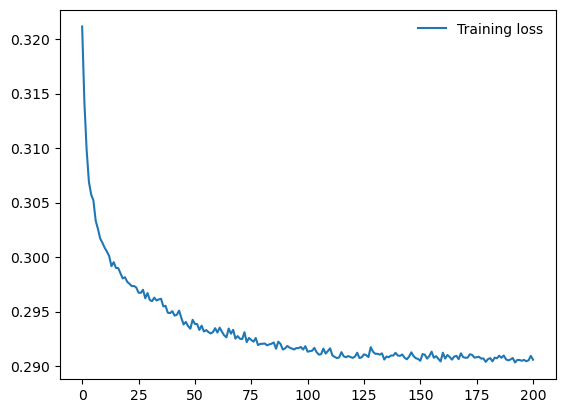

In [8]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(historical_loss, label='Training loss')
plt.legend(frameon=False)


In [11]:
# Define a filepath to save the model
filepath = 'siamese_network_1_training.pth'

# Save the model’s state_dict
torch.save(best_model.state_dict(), filepath)

### Alterantive Dataloading Training Script Training
Below I am running training again using an adjusted training script from the one above that uses a slightly different strategy to load in batches. See train_mnist_alterante_dataloading.py for the explanation

In [3]:
from train_mnist_alternate_dataloading import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#set epochs
epochs = 1000

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 20

#set log frequency for model eval 
log_frequency = 1

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   log_freq = log_frequency, 
                   batch_size=256)

Device: cuda


In [4]:
import time

print("starting training...\n\n")

start = time.time()

best_model, historical_loss, historical_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

starting training...


Epoch 0: Train Loss: 0.34103 -- Train Accuracy 0.277 -- Val Loss: 0.31235 -- Val Accuracy: 0.296
Epoch 1: Train Loss: 0.32553 -- Train Accuracy 0.313 -- Val Loss: 0.30628 -- Val Accuracy: 0.317
Epoch 2: Train Loss: 0.32036 -- Train Accuracy 0.328 -- Val Loss: 0.30352 -- Val Accuracy: 0.324
Epoch 3: Train Loss: 0.31867 -- Train Accuracy 0.335 -- Val Loss: 0.30066 -- Val Accuracy: 0.337
Epoch 4: Train Loss: 0.31647 -- Train Accuracy 0.346 -- Val Loss: 0.29886 -- Val Accuracy: 0.350
Epoch 5: Train Loss: 0.31572 -- Train Accuracy 0.354 -- Val Loss: 0.29845 -- Val Accuracy: 0.352
Epoch 6: Train Loss: 0.31432 -- Train Accuracy 0.357 -- Val Loss: 0.29767 -- Val Accuracy: 0.354
Epoch 7: Train Loss: 0.31406 -- Train Accuracy 0.362 -- Val Loss: 0.29761 -- Val Accuracy: 0.366
Epoch 8: Train Loss: 0.31366 -- Train Accuracy 0.364 -- Val Loss: 0.29685 -- Val Accuracy: 0.359
Epoch 9: Train Loss: 0.31402 -- Train Accuracy 0.363 -- Val Loss: 0.29607 -- Val Accuracy: 0.363
Epoch 1

Matplotlib is building the font cache; this may take a moment.


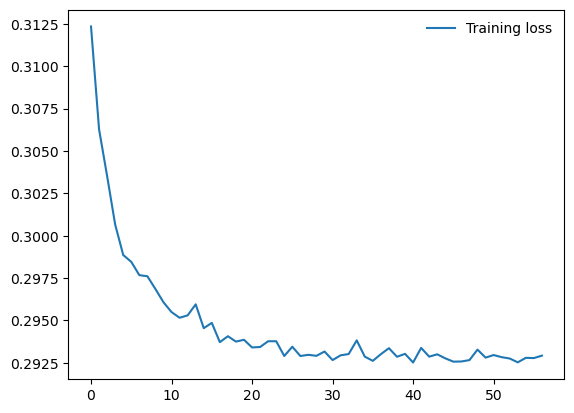

In [5]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(historical_loss, label='Training loss')
plt.legend(frameon=False)


### Reimplementation of the above, but with shuffling of the iterator before epoch begins

In [3]:
from train_mnist_alternate_dataloading import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#set epochs
epochs = 1000

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 20

#set log frequency for model eval 
log_frequency = 1

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   log_freq = log_frequency, 
                   batch_size=256)

Device: cuda


In [4]:
import time

print("starting training...\n\n")

start = time.time()

best_model, historical_loss, historical_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

starting training...


Epoch 0: Train Loss: 0.45005 -- Train Accuracy 0.282 -- Val Loss: 0.32765 -- Val Accuracy: 0.264
Epoch 1: Train Loss: 0.29576 -- Train Accuracy 0.229 -- Val Loss: 0.32600 -- Val Accuracy: 0.269
Epoch 2: Train Loss: 0.56459 -- Train Accuracy 0.449 -- Val Loss: 0.32445 -- Val Accuracy: 0.271
Epoch 3: Train Loss: 0.66113 -- Train Accuracy 0.539 -- Val Loss: 0.32109 -- Val Accuracy: 0.283
Epoch 4: Train Loss: 0.09363 -- Train Accuracy 0.077 -- Val Loss: 0.32132 -- Val Accuracy: 0.282
Epoch 5: Train Loss: 0.05818 -- Train Accuracy 0.049 -- Val Loss: 0.32110 -- Val Accuracy: 0.281
Epoch 6: Train Loss: 0.12206 -- Train Accuracy 0.102 -- Val Loss: 0.32058 -- Val Accuracy: 0.283
Epoch 7: Train Loss: 0.43505 -- Train Accuracy 0.366 -- Val Loss: 0.31982 -- Val Accuracy: 0.282
Epoch 8: Train Loss: 0.32279 -- Train Accuracy 0.278 -- Val Loss: 0.31879 -- Val Accuracy: 0.284
Epoch 9: Train Loss: 0.13176 -- Train Accuracy 0.117 -- Val Loss: 0.31862 -- Val Accuracy: 0.284
Epoch 1

Epoch 84: Train Loss: 0.58175 -- Train Accuracy 0.622 -- Val Loss: 0.29938 -- Val Accuracy: 0.341
Epoch 85: Train Loss: 0.39257 -- Train Accuracy 0.414 -- Val Loss: 0.29930 -- Val Accuracy: 0.342
Epoch 86: Train Loss: 0.40751 -- Train Accuracy 0.433 -- Val Loss: 0.29914 -- Val Accuracy: 0.340
Epoch 87: Train Loss: 0.42315 -- Train Accuracy 0.452 -- Val Loss: 0.29929 -- Val Accuracy: 0.340
Epoch 88: Train Loss: 0.35321 -- Train Accuracy 0.375 -- Val Loss: 0.29885 -- Val Accuracy: 0.341
Epoch 89: Train Loss: 0.34205 -- Train Accuracy 0.365 -- Val Loss: 0.29885 -- Val Accuracy: 0.342
Epoch 90: Train Loss: 0.57515 -- Train Accuracy 0.615 -- Val Loss: 0.29871 -- Val Accuracy: 0.343
Epoch 91: Train Loss: 0.09228 -- Train Accuracy 0.099 -- Val Loss: 0.29896 -- Val Accuracy: 0.342
Epoch 92: Train Loss: 0.03771 -- Train Accuracy 0.041 -- Val Loss: 0.29871 -- Val Accuracy: 0.344
Epoch 93: Train Loss: 0.58613 -- Train Accuracy 0.626 -- Val Loss: 0.29842 -- Val Accuracy: 0.342
Epoch 94: Train Loss

Epoch 167: Train Loss: 0.03180 -- Train Accuracy 0.036 -- Val Loss: 0.29386 -- Val Accuracy: 0.347
Epoch 168: Train Loss: 0.44741 -- Train Accuracy 0.501 -- Val Loss: 0.29400 -- Val Accuracy: 0.346
Epoch 169: Train Loss: 0.11708 -- Train Accuracy 0.132 -- Val Loss: 0.29410 -- Val Accuracy: 0.349
Epoch 170: Train Loss: 0.50697 -- Train Accuracy 0.560 -- Val Loss: 0.29390 -- Val Accuracy: 0.345
Epoch 171: Train Loss: 0.55416 -- Train Accuracy 0.620 -- Val Loss: 0.29399 -- Val Accuracy: 0.348
Epoch 172: Train Loss: 0.57662 -- Train Accuracy 0.639 -- Val Loss: 0.29386 -- Val Accuracy: 0.346
Epoch 173: Train Loss: 0.04780 -- Train Accuracy 0.053 -- Val Loss: 0.29400 -- Val Accuracy: 0.344
Epoch 174: Train Loss: 0.47807 -- Train Accuracy 0.538 -- Val Loss: 0.29397 -- Val Accuracy: 0.346
Epoch 175: Train Loss: 0.43180 -- Train Accuracy 0.482 -- Val Loss: 0.29390 -- Val Accuracy: 0.346

Training time: 2172.7596051692963


Matplotlib is building the font cache; this may take a moment.


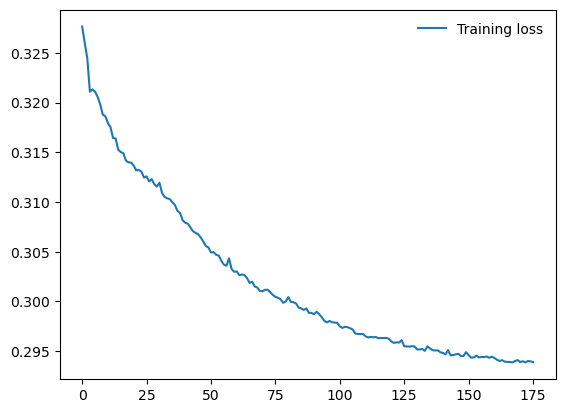

In [5]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(historical_loss, label='Validation loss')
plt.legend(frameon=False)


Following this experi9ement, my intuition for which training script is the best allies with mnist_train_alternate_dataloading.py. It is the most readable and easiest to debug. 

It did not perform the best with the specific model in this experiment, but the point of the experiemnt was not to optimize. It is probably the case that it is a better training script for a better model.